## SSD Single Shot  Multibox Object Detection
This model is a Fastai V1 implementation using SSD architecture.

In [1]:
import datetime
str(datetime.datetime.now())

'2019-08-30 00:28:28.926855'

### Initialization

In [2]:
import os
NUM_PARALLEL_UNITS = 4
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
__version__

'1.0.57'

### Download Pascal 20007 database

In [5]:
URLs.PASCAL_2007

'https://s3.amazonaws.com/fast-ai-imagelocal/pascal_2007'

In [6]:
cd c:\beans-home\data

c:\beans-home\data


In [7]:
pwd

'c:\\beans-home\\data'

In [8]:
# Download {Pascal 20007 database}
path = untar_data(URLs.PASCAL_2007); path.ls()

[WindowsPath('C:/beans-home/data/data/pascal_2007/test'),
 WindowsPath('C:/beans-home/data/data/pascal_2007/test.json'),
 WindowsPath('C:/beans-home/data/data/pascal_2007/train'),
 WindowsPath('C:/beans-home/data/data/pascal_2007/train.json'),
 WindowsPath('C:/beans-home/data/data/pascal_2007/valid.json')]

### Data Preparation

In [9]:
# Deals with both GPU and CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');device

device(type='cuda')

In [10]:
torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(0, 1, 'Quadro RTX 5000')

In [11]:
json_file = Path('C:/Users/sande/.fastai/data/pascal_2007/test.json')

In [12]:
import json
json_train = json.loads(json_file.read_text())

In [13]:
json_train['images'][:5]

[{'file_name': '000001.jpg', 'height': 500, 'width': 353, 'id': 1},
 {'file_name': '000002.jpg', 'height': 500, 'width': 335, 'id': 2},
 {'file_name': '000003.jpg', 'height': 375, 'width': 500, 'id': 3},
 {'file_name': '000004.jpg', 'height': 406, 'width': 500, 'id': 4},
 {'file_name': '000006.jpg', 'height': 375, 'width': 500, 'id': 6}]

In [14]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above - Image file name to annotation BB's with classes for BBs
img_y_dict = dict(zip(tot_im_names, tot_truths))

# Define a function, based on the dictionary created above, to use in a Fastai Data Block to structure the input data
truth_data_func = lambda o: img_y_dict[o.name]

In [15]:
# For Instrospection:
print(trn_im_names[:2])
print(trn_truths[1],'\n',trn_truths[2])
img_y_dict['000017.jpg']
#doc(get_annotations)

['000012.jpg', '000017.jpg']
[[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']] 
 [[[229, 8, 500, 245], [219, 229, 500, 334], [177, 1, 500, 90], [0, 1, 369, 117], [1, 2, 462, 243], [0, 224, 486, 334]], ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']]


[[[61, 184, 199, 279], [77, 89, 336, 403]], ['person', 'horse']]

### Create Fastai DataBunch

In [16]:
sz=224       # Image size
bs=32   #Collab: 64        # Batch size

In [17]:
np.random.seed(35) # For reproducibility
tfms = get_transforms(cutout(n_holes=(1,4), length=(10, 160), p=.5), max_rotate=4., max_zoom=1.1, p_affine=0.5, p_lighting=0.5 )
data = (ObjectItemList 
        .from_folder(path/'train')
        .split_by_rand_pct(0.02)
        .label_from_func(truth_data_func) 
        .transform(tfms=tfms,size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

C:\Users\sande\.conda\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


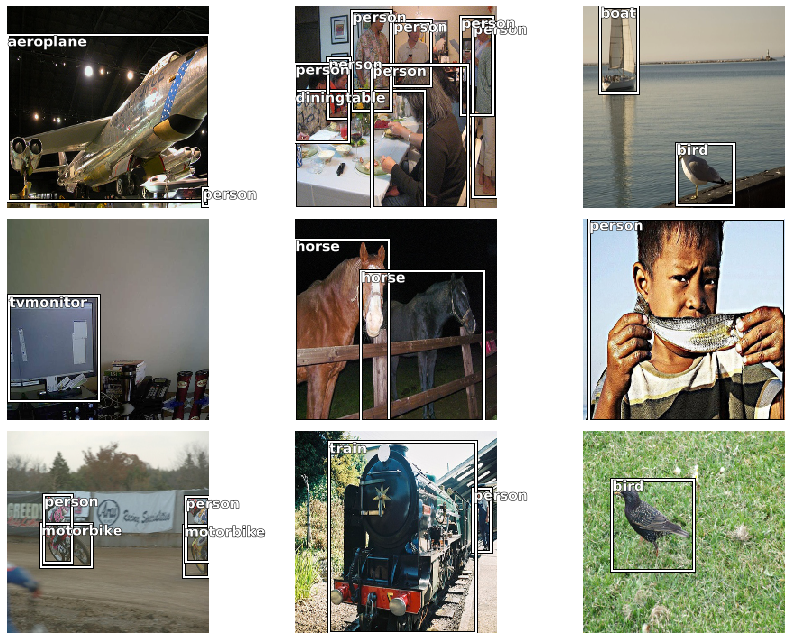

In [18]:
data.show_batch(rows=3, figsize=(12,9))

### Show single image

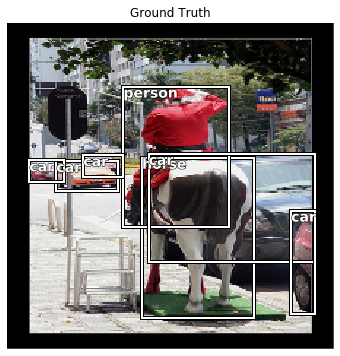

In [19]:
idx = 17

xb, yb= next(iter(data.valid_dl))

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions 

In [20]:
# Filter out all zero-valued bounding boxes
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert center/height/width to fastai top left and bottom right coordinates
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

# Transform activations to bounding box format
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

  # Map to Ground Truth
def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

### Helper Functions - Anchor Boxes

In [21]:

anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)


In [22]:
# anchor_scales
# anc_offsets
# anc_ctrs.shape
# anc_sizes
# grid_sizes

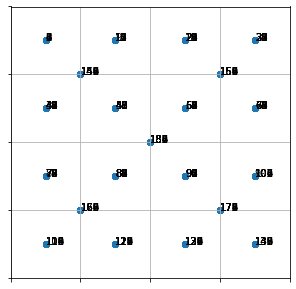

In [23]:
show_anchors(anchors,(4,4))

### Optimal Learning Rate Search

In [24]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
      if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
      return True 
    else:
      return False
    
  
  
def find_optimal_lr(learner, noise=5, show_df=None, show_min_values=False):
    '''
    Parameters
    
      learner:  The learner (mandatory)
      
      (Optional)
      noise:   Filtering parameter, set to 5. Suggest no to modify this value
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested Best Slice - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 5 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss )
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad)
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red)    
    ax2.scatter(df.lrs, df.min_grad, c = color_red)    
    if show_min_values:
      ax.scatter(df.lrs, df.max_loss, c = color_green)
      ax2.scatter(df.lrs, df.max_grad, c = color_green) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learn):
      # Yellow min_grad graph
      rev_tru_idx = df.min_grad.notna()[::-1]   
      optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
      # Blue loss graph
      rev_tru_idx_loss = df.min_loss.notna()[::-1]   
      optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      
      # Print results and return choices of lr slice
      print('Model set to: "unfreeze" or "freeze_to:"')      
      data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
      prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
      pd.options.display.float_format = '{:.10E}'.format
      #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
      print(prdf)
       
      return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        
      optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
      optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
      # Print results and return optimal lr
      print('Model set to "freeze":')
      print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
      print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
      return optimun_lr_upper_bound 
     

### Model

To solve this object detection problem, we are going to create **a custom model using Torch.**
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detetion. For initial design and testing, we use ResNet34.

In [25]:
# Number of classes in the data set
no_cls = len(data.classes); no_cls

21

In [26]:
data.classes # note data.classes[0] is background

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [27]:
# model 
f_model = models.resnet34

In [28]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
        #self.conv_class.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [29]:
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.2)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1)
        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer
        # Standard layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

### SSD Loss

---


In [30]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
# Class loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes,focal_loss=False):
    
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

# Bounding-box loss computation, based on fixed Anchor Boxes and L! Loss
def single_ssd_loss(pbox,plabel,box,label):
  
    # Compute the jaccard (overlap) between ground truth and anchor boxes
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) # Map anchors into Fastai format: top-left and bottom-right coordinates
    bbox,clas = un_pad(box,label) # Filter all non-zero boxes
    overlaps = iou(bbox,base_box.to(device))  # Calculate iou for anchor and target box
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    # Map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    
    # Positive predictions have overlaps greater than 0.4
    pos = gt_overlaps > 0.4
    gt_clas[1-pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #Ground truth labels
    pos_idx = torch.nonzero(pos)[:,0] 
    gt_bbox = bbox[gt_idx]  # Selected ground truth box
    
    # Map predicted bounding box to anchor and convert it to Fastai format: top-left and bottom-right coordinates
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) 
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.to(device)
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss
  
# loss function
loss_f = ssd_loss

### Learner

In [31]:
f_model

<function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>

In [32]:
md = ssd_model(f_model, k=k, no_cls=no_cls, drop=0.3)

In [33]:
learn = Learner(data, md, loss_func=loss_f)

### Split Model

In [34]:
# Create Layer Groups
learn.split(lambda m: (m.body[6], m.drop))
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

### Fit

In [35]:
# Find Finder
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


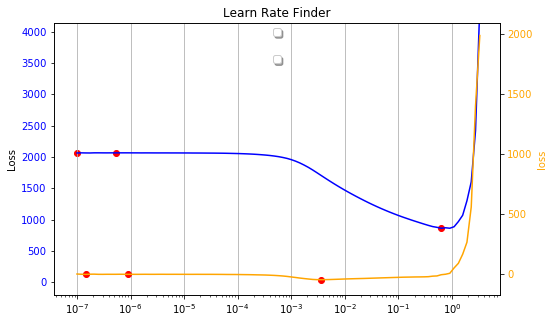

Model set to "freeze":
  Optimun lr: 3.6307806149E-03 
  Min loss divided by 10: 6.3095736504E-02


In [36]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn);

In [37]:
import datetime

In [38]:
startTime = datetime.datetime.now()
learn.fit_one_cycle(5, 3.6307806149E-03)
endTime = datetime.datetime.now()
print(endTime-startTime)

epoch,train_loss,valid_loss,time
0,132.607315,18.469925,04:42
1,25.006050,18.180845,04:23
2,19.025297,16.353273,04:14
3,17.004591,14.352248,04:14
4,15.742683,13.655797,04:42


0:22:17.073231


In [39]:
learn.save(F'c:/beans-home/data/models/ssd_basic')

In [40]:
learn.load(F'c:/beans-home/data/models/ssd_basic', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

#### Train Last Two Layers

In [41]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


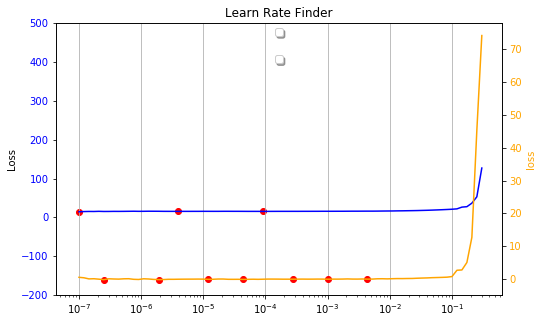

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            4.3651582673E-03     9.1201087344E-05
Second choice lr:           1.0000000475E-03     3.9810715862E-06
Third choice lr:            2.7542287717E-04     1.0000000117E-07


In [43]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [44]:
lr

(0.001, 0.0043651583)

In [45]:
startTime = datetime.datetime.now()
learn.fit_one_cycle(10, slice(1e-5, 6.3095735386E-03))
endTime = datetime.datetime.now()
print(endTime-startTime)

epoch,train_loss,valid_loss,time
0,15.614610,14.354475,04:13
1,15.892119,15.626551,04:09
2,15.537545,13.686131,04:06
3,14.489430,12.923162,04:10
4,13.760718,12.357129,04:08
5,13.051634,11.521764,04:10
6,11.939407,10.909252,04:08
7,11.338889,10.333114,04:08
8,10.860594,10.221092,04:10
9,10.321485,10.092087,04:09


0:41:35.096091


In [46]:
learn.save(F'c:/beans-home/data/models/ssd_freeze_2_1')

In [47]:
learn.load(F'c:/beans-home/data/models/ssd_freeze_2_1', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [48]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


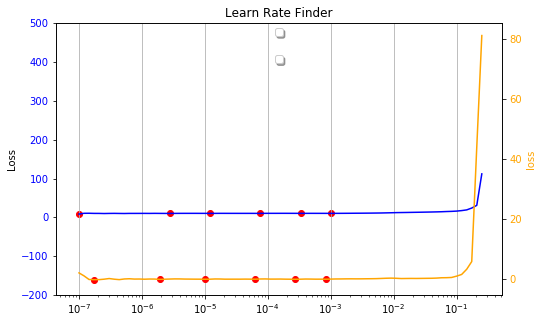

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            8.3176378394E-04     1.0000000475E-03
Second choice lr:           2.7542287717E-04     3.3113113022E-04
Third choice lr:            6.3095736550E-05     7.5857758929E-05


In [50]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [51]:
learn.fit_one_cycle(15, slice(5.7543994626E-04))

epoch,train_loss,valid_loss,time
0,10.347684,9.978253,04:06
1,10.188239,10.026109,04:07
2,10.272419,10.028012,04:06
3,10.293653,10.069028,04:05
4,10.127242,9.870430,04:05
5,10.019393,9.731968,04:07
6,9.866199,9.810734,04:06
7,9.679496,9.841926,04:08
8,9.675269,9.704676,04:08
9,9.446863,9.650149,04:07


In [52]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_2_2')

In [53]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_2_2', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [54]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


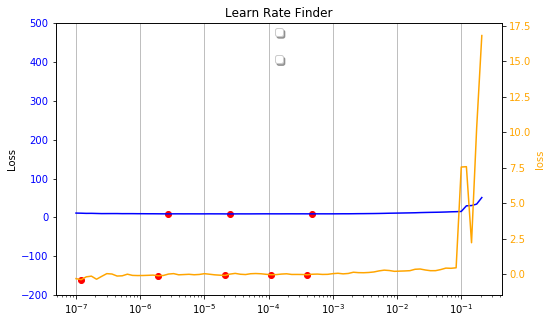

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.9810716407E-04     4.7863009968E-04
Second choice lr:           1.0964782268E-04     2.5118864869E-05
Third choice lr:            2.0892961402E-05     2.7542287171E-06


In [56]:
lr = find_optimal_lr(learn)

In [57]:
learn.fit_one_cycle(13, slice(1.2022644114E-05, 3.3113113022E-04))

epoch,train_loss,valid_loss,time
0,9.173126,9.637787,04:09
1,9.161685,9.606776,04:07
2,9.199314,9.849211,04:07
3,9.173530,9.961747,04:08
4,9.105834,9.803340,04:07
5,9.187175,9.655661,04:07
6,9.052427,9.760793,04:06
7,8.851627,9.546759,04:06
8,8.917328,9.500752,04:06
9,8.724873,9.557584,04:08


In [58]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_2_3')

In [59]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_2_3', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

#### Unfreeze and Train

In [60]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


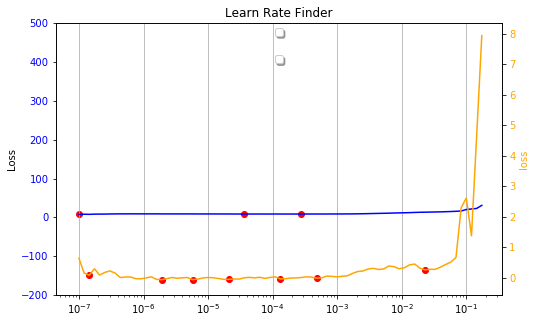

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.2908676416E-02     2.7542287717E-04
Second choice lr:           4.7863009968E-04     3.6307807022E-05
Third choice lr:            1.3182566909E-04     1.0000000117E-07


In [62]:
lr = find_optimal_lr(learn)

In [63]:
learn.fit_one_cycle(13, slice(6e-6, 8.3176378394E-04 ))

epoch,train_loss,valid_loss,time
0,8.623865,9.685866,04:09
1,8.662257,9.583868,04:09
2,8.789790,9.827810,04:09
3,9.005829,9.766160,04:08
4,8.943621,9.738530,04:09
5,8.794272,9.835053,04:10
6,8.798565,9.904257,04:09
7,8.685485,9.807875,04:06
8,8.477294,9.613590,03:54
9,8.326001,9.675397,03:52


In [64]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_4')

In [65]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_4', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [66]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


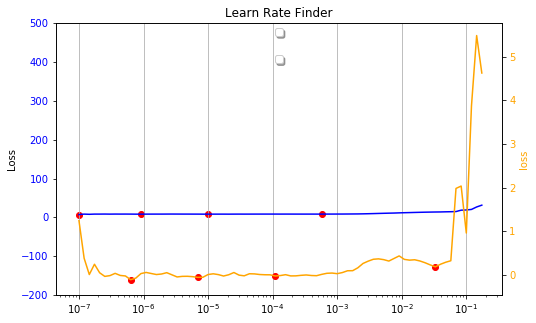

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.3113110811E-02     5.7543994626E-04
Second choice lr:           1.0964782268E-04     9.9999997474E-06
Third choice lr:            6.9183097366E-06     9.1201081887E-07


In [68]:
lr = find_optimal_lr(learn)

In [69]:
learn.fit_one_cycle(13, slice(4.7863009968E-04))

epoch,train_loss,valid_loss,time
0,8.200307,9.519171,03:53
1,8.236837,9.503150,03:51
2,8.295889,9.591958,03:51
3,8.345244,9.687451,03:51
4,8.400188,9.539190,03:52
5,8.262701,9.326702,03:51
6,8.242085,9.436084,03:52
7,8.173722,9.459585,03:51
8,7.948040,9.471895,03:51
9,7.868194,9.348028,03:51


In [70]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_5')

In [71]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_5', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [72]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


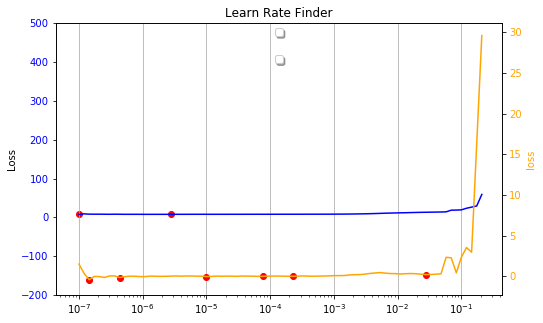

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.7542287484E-02     2.7542287171E-06
Second choice lr:           2.2908677056E-04     1.0000000117E-07
Third choice lr:            7.5857758929E-05     2.0892961323E-01


In [74]:
lr = find_optimal_lr(learn)

In [75]:
learn.fit_one_cycle(13, slice(3.9810716407E-04))

epoch,train_loss,valid_loss,time
0,7.907246,9.395695,03:52
1,7.815116,9.454181,03:51
2,8.005824,9.476270,03:51
3,7.959333,8471.959961,03:52
4,7.956921,9.523842,03:52
5,7.955336,9.510133,03:51
6,7.914593,9.479381,03:51
7,7.880537,9.485627,03:51
8,7.841332,9.479623,03:51
9,7.748000,9.402151,03:51


In [77]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_7')

In [78]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_7', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [79]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [80]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


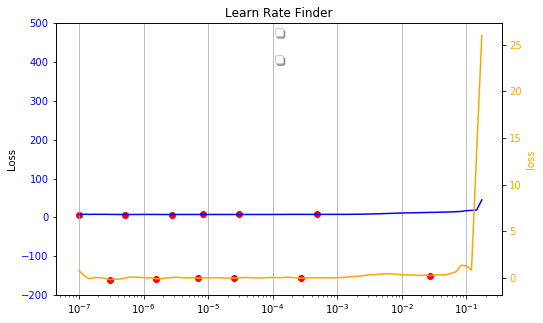

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.7542287484E-02     4.7863009968E-04
Second choice lr:           2.7542287717E-04     3.0199516914E-05
Third choice lr:            2.5118864869E-05     8.3176373664E-06


In [81]:
lr = find_optimal_lr(learn)

In [82]:
learn.fit_one_cycle(13, slice(6.0e-06))

epoch,train_loss,valid_loss,time
0,7.612938,9.432513,03:51
1,7.594383,9.368671,03:52
2,7.598416,9.457561,03:52
3,7.559931,9.354244,03:52
4,7.782661,9.282212,03:53
5,7.725160,9.373552,03:59
6,7.553787,9.447722,05:22
7,7.673646,9.328890,05:45
8,7.580496,9.406448,05:56
9,7.475277,9.405932,06:07


In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


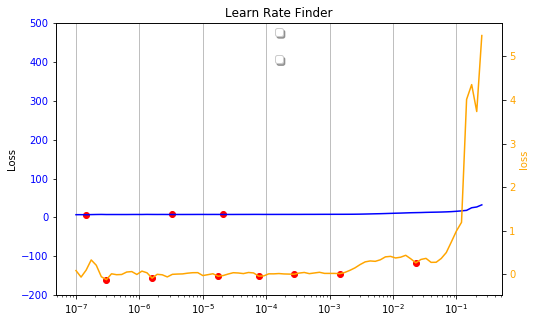

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.2908676416E-02     2.0892961402E-05
Second choice lr:           1.4454397606E-03     3.3113112750E-06
Third choice lr:            2.7542287717E-04     1.4454397501E-07


In [84]:
lr = find_optimal_lr(learn)

In [85]:
learn.fit_one_cycle(5, slice(1E-7))

epoch,train_loss,valid_loss,time
0,7.679143,9.355663,04:17
1,7.575182,9.385538,04:14
2,7.673407,9.320934,04:02
3,7.606822,9.410415,04:09
4,7.672460,9.388908,04:38


In [86]:
learn.save(F'c:/beans-home/data/models/ssd_unfreeze_6')

In [87]:
learn.load(F'c:/beans-home/data/models/ssd_unfreeze_6', strict=True)

Learner(data=ImageDataBunch;

Train: LabelList (4911 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Valid: LabelList (100 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: C:\beans-home\data\data\pascal_2007\train;

Test: None, model=ssd_model(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

### Display predicted image and ground truth

In [88]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)

In [89]:
# Select sample image and unpad it
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
#t_bbox,t_clas

# Predicted class
p_cls_test = preds[1][idx][:,1:].max(dim=1)
#p_cls_test

# Threshold
idx_clas = p_cls_test[0].sigmoid() > 0.1
#idx_clas


p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
#p_f_clas

In [90]:
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

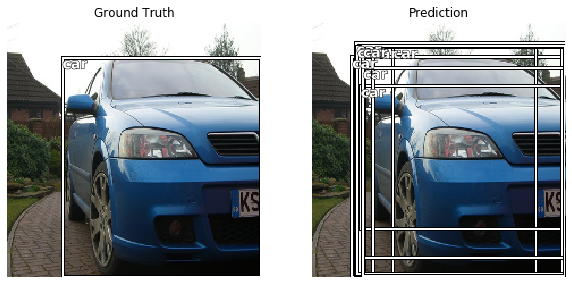

In [91]:
show_img_by_ndx(15)

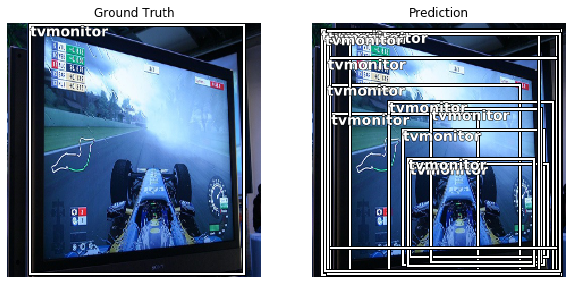

In [92]:
show_img_by_ndx(2)

### Non-Max Suppression

In [93]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### NMS  Algorithm

In [94]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

### Image Filtering Methods

In [95]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)
b_bb, b_clas = preds

In [112]:
type(b_bb), b_bb.shape

(torch.Tensor, torch.Size([32, 189, 4]))

In [117]:
b_bb[0][0]

tensor([ 0.2494,  0.3223, -0.3863, -0.7421], device='cuda:0',
       grad_fn=<SelectBackward>)

In [119]:
b_clas[0][0]

tensor([ 0.0358, -7.1575, -6.5887, -5.5420, -5.3460, -7.2989, -6.8422, -5.4102,
        -7.3329, -6.0652, -4.7956, -9.5387, -5.6019, -5.8469, -5.7369, -4.2951,
        -6.2621, -5.3815, -6.4702, -7.2404, -6.7563], device='cuda:0',
       grad_fn=<SelectBackward>)

In [120]:
b_clas[0][1]

tensor([  0.1670,  -9.3490,  -8.1263,  -6.7920,  -6.8072,  -9.1878,  -8.8529,
         -6.4560,  -8.7371,  -7.3673,  -4.8853, -12.9542,  -6.4916,  -6.4819,
         -6.6013,  -5.0869,  -8.1256,  -6.5234,  -8.3631,  -9.1537,  -8.9222],
       device='cuda:0', grad_fn=<SelectBackward>)

In [124]:
b_clas[1][18]

tensor([ -0.0322, -12.3964, -10.1668,  -9.6683, -10.2728,  -5.7674, -12.1336,
         -8.7739, -10.1428,  -6.2641, -10.7336,  -9.7017, -10.4225, -13.0355,
        -11.1340,  -6.1399,  -5.5771, -10.7608,  -8.7305, -11.3124,  -6.7733],
       device='cuda:0', grad_fn=<SelectBackward>)

In [96]:
def process_nmf(idx):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.30     #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.1 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)
    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = data.classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays
        c_mask = conf_scores[cl] > min_thresh
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
            
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.to(device).index_select(dim=0,index=c_mask.nonzero().squeeze())
            
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=50)
        ids = ids[:count]
        
    
        
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{data.classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class list is empty. Image may be too faint.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst

In [97]:
# Filter Single Image
def show_filtered_img_by_ndx(idx):
    
    
    # Prepare ground-truth image for display
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction', color=colr_list[11])
   
 

### Filter Image Sets

In [98]:
#Filter Image Sets
show_filtered_img_by_ndx(8)

Inferred Class list is empty. Image may be too faint.


Inferred Class list is empty. Image may be too faint.


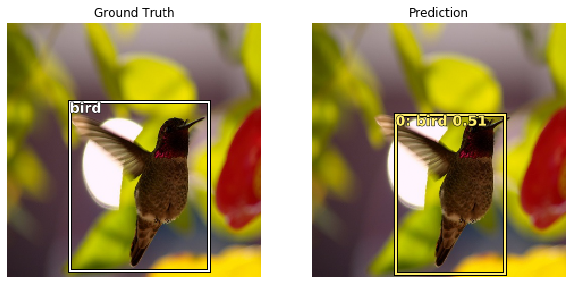

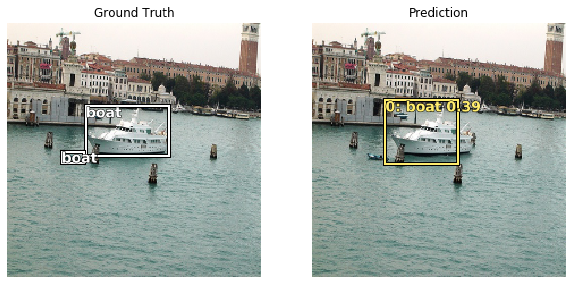

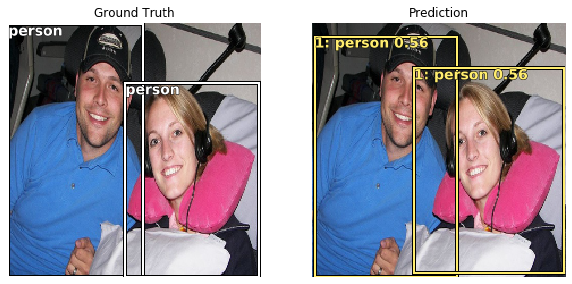

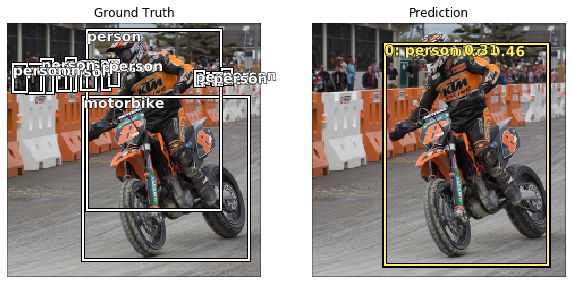

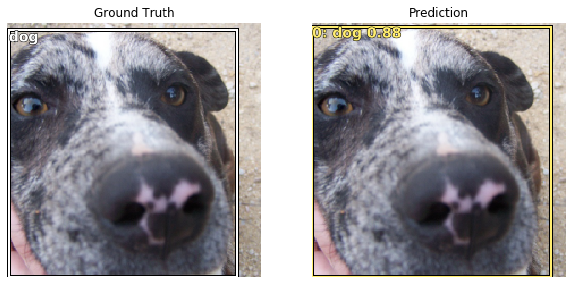

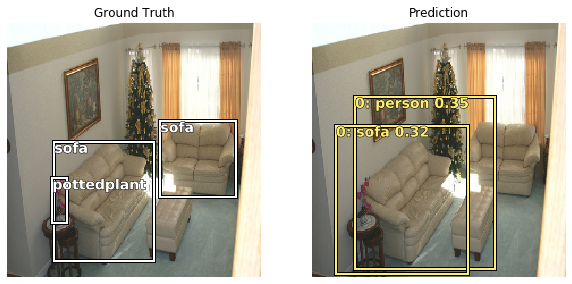

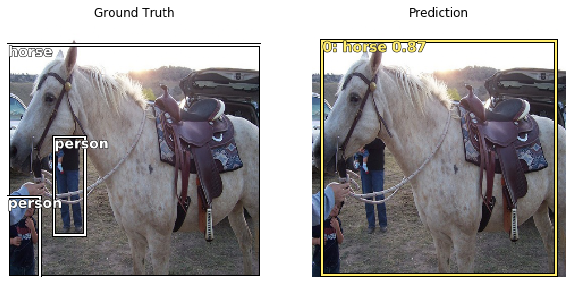

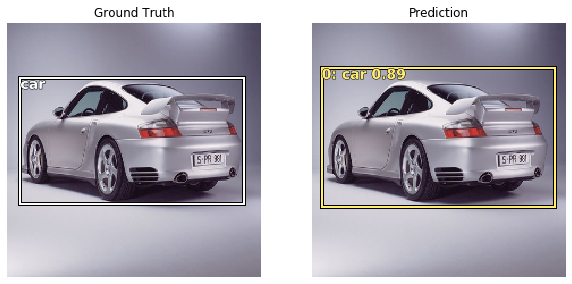

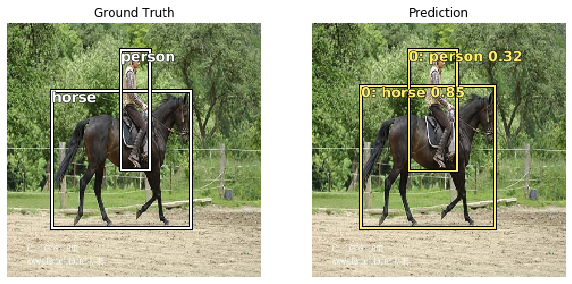

In [100]:
for i in range(20,30): show_filtered_img_by_ndx(i)

# FIN

In [101]:
str(datetime.datetime.now())

'2019-08-30 10:48:22.970844'

### Prediction after training 

In [104]:
!dir c:\beans-home\data\models

 Volume in drive C is Windows
 Volume Serial Number is AA1A-7B31

 Directory of c:\beans-home\data\models

08/30/2019  10:41 AM    <DIR>          .
08/30/2019  10:41 AM    <DIR>          ..
08/30/2019  12:54 AM       139,511,681 ssd_basic.pth
08/30/2019  01:38 AM       298,902,107 ssd_freeze_2_1.pth
08/30/2019  02:42 AM       298,902,111 ssd_unfreeze_2_2.pth
08/30/2019  03:38 AM       298,902,109 ssd_unfreeze_2_3.pth
08/30/2019  04:32 AM       309,665,049 ssd_unfreeze_4.pth
08/30/2019  05:25 AM       309,665,047 ssd_unfreeze_5.pth
08/30/2019  10:41 AM       309,665,051 ssd_unfreeze_6.pth
08/30/2019  09:10 AM       309,665,049 ssd_unfreeze_7.pth
               8 File(s)  2,274,878,204 bytes
               2 Dir(s)  795,614,076,928 bytes free


In [106]:
#We will use the latest model as:
!dir c:\beans-home\data\models\ssd_unfreeze_7.pth

 Volume in drive C is Windows
 Volume Serial Number is AA1A-7B31

 Directory of c:\beans-home\data\models

08/30/2019  09:10 AM       309,665,049 ssd_unfreeze_7.pth
               1 File(s)    309,665,049 bytes
               0 Dir(s)  795,613,560,832 bytes free


In [108]:
#Test file is:
!dir c:\beans-home\data\data\pascal_2007\000013.jpg

 Volume in drive C is Windows
 Volume Serial Number is AA1A-7B31

 Directory of c:\beans-home\data\data\pascal_2007

01/09/2007  04:17 AM           133,840 000013.jpg
               1 File(s)        133,840 bytes
               0 Dir(s)  795,611,680,768 bytes free


In [109]:
%whos

Variable                                 Type                          Data/Info
--------------------------------------------------------------------------------
AUROC                                    type                          <class 'fastai.metrics.AUROC'>
AccumulateScheduler                      type                          <class 'fastai.train.AccumulateScheduler'>
ActivationStats                          type                          <class 'fastai.callbacks.hooks.ActivationStats'>
AdamW                                    partial                       functools.partial(<class <...>dam'>, betas=(0.9, 0.99))
AdaptiveConcatPool2d                     PrePostInitMeta               <class 'fastai.layers.AdaptiveConcatPool2d'>
AffineFunc                               _GenericAlias                 typing.Callable[[typing.D<...>ping.Any]], torch.Tensor]
AffineMatrix                             type                          <class 'torch.Tensor'>
AnnealFunc                            

Image                                    type                          <class 'fastai.vision.image.Image'>
ImageBBox                                type                          <class 'fastai.vision.image.ImageBBox'>
ImageDataBunch                           type                          <class 'fastai.vision.data.ImageDataBunch'>
ImageImageList                           type                          <class 'fastai.vision.data.ImageImageList'>
ImageList                                type                          <class 'fastai.vision.data.ImageList'>
ImagePoints                              type                          <class 'fastai.vision.image.ImagePoints'>
ImageSegment                             type                          <class 'fastai.vision.image.ImageSegment'>
ImgLabel                                 type                          <class 'str'>
ImgLabels                                _GenericAlias                 typing.Collection[str]
InitVar                             

ObjectCategoryList                       type                          <class 'fastai.vision.data.ObjectCategoryList'>
ObjectItemList                           type                          <class 'fastai.vision.data.ObjectItemList'>
OneCycleScheduler                        type                          <class 'fastai.callbacks.<...>cycle.OneCycleScheduler'>
OptDataFrame                             _GenericAlias                 typing.Union[pandas.core.<...>rame.DataFrame, NoneType]
OptListOrItem                            _GenericAlias                 typing.Union[typing.Colle<...>nt, float, str, NoneType]
OptLossFunc                              _GenericAlias                 typing.Union[typing.Calla<...> OneEltTensor], NoneType]
OptMetrics                               _GenericAlias                 typing.Union[typing.Colle<...>mbers.Number]], NoneType]
OptOptimizer                             _GenericAlias                 typing.Union[torch.optim.<...>izer.Optimizer, NoneType]
OptR

StrList                                  _GenericAlias                 typing.Collection[str]
Tensor                                   type                          <class 'torch.Tensor'>
TensorDataset                            type                          <class 'torch.utils.data.dataset.TensorDataset'>
TensorImage                              type                          <class 'torch.Tensor'>
TensorImageSize                          _GenericAlias                 typing.Tuple[int, int, int]
TensorOrNumList                          _GenericAlias                 typing.Collection[typing.<...>.Tensor, numbers.Number]]
TensorOrNumber                           _GenericAlias                 typing.Union[torch.Tensor, numbers.Number]
Tensors                                  _GenericAlias                 typing.Union[torch.Tensor<...>n[ForwardRef('Tensors')]]
TerminateOnNaNCallback                   type                          <class 'fastai.callbacks.<...>.TerminateOnNaNCallback'>
TfmA

box_area                                 function                      <function box_area at 0x0000028B1B3705E8>
brightness                               TfmLighting                   TfmLighting (brightness)
bs                                       int                           32
bunzip                                   function                      <function bunzip at 0x0000028B12316828>
bz2                                      module                        <module 'bz2' from 'C:\\U<...>\fastai_v1\\lib\\bz2.py'>
callback                                 module                        <module 'fastai.callback'<...>es\\fastai\\callback.py'>
callbacks                                module                        <module 'fastai.callbacks<...>\callbacks\\__init__.py'>
camel2snake                              function                      <function camel2snake at 0x0000028B12309C18>
channel_view                             function                      <function channel_view at 0x0000028B19

fastai_types                             dict                          n=59
fbeta                                    function                      <function fbeta at 0x0000028B0DA5DAF8>
field                                    function                      <function field at 0x0000028B10AD10D8>
fig                                      Figure                        Figure(720x432)
find_classes                             function                      <function find_classes at 0x0000028B123099D8>
find_optimal_lr                          function                      <function find_optimal_lr at 0x0000028B19AB3DC8>
first_el                                 function                      <function first_el at 0x0000028B12309678>
first_layer                              function                      <function first_layer at 0x0000028B1231D4C8>
fit                                      function                      <function fit at 0x0000028B123DAD38>
fit_one_cycle                            fu

join_paths                               function                      <function join_paths at 0x0000028B123145E8>
json                                     module                        <module 'json' from 'C:\\<...>\lib\\json\\__init__.py'>
json_file                                WindowsPath                   C:\Users\sande\.fastai\data\pascal_2007\test.json
json_train                               dict                          n=4
k                                        int                           9
last_layer                               function                      <function last_layer at 0x0000028B1231D558>
layers                                   module                        <module 'fastai.layers' f<...>ages\\fastai\\layers.py'>
learn                                    Learner                       Learner(data=ImageDataBun<...>, cb_fns_registered=True)
listify                                  function                      <function listify at 0x0000028B12309B88>
load_dat

p_cls_test                               tuple                         n=2
p_f_clas                                 Tensor                        tensor([ 0,  0,  0,  0,  <...> 0,  0], device='cuda:0')
pad                                      TfmPixel                      TfmPixel (pad)
parallel                                 function                      <function parallel at 0x0000028B12316438>
partial                                  type                          <class 'functools.partial'>
partition                                function                      <function partition at 0x0000028B12309DC8>
partition_by_cores                       function                      <function partition_by_co<...>es at 0x0000028B12309E58>
patches                                  module                        <module 'matplotlib.patch<...>\matplotlib\\patches.py'>
path                                     WindowsPath                   C:\beans-home\data\data\pascal_2007
patheffects              

sixel                                    module                        <module 'fastai.sixel' fr<...>kages\\fastai\\sixel.py'>
skew                                     TfmCoord                      TfmCoord (skew)
spectral_norm                            function                      <function spectral_norm at 0x0000028B12183B88>
split_kwargs_by_func                     function                      <function split_kwargs_by<...>nc at 0x0000028B12314A68>
split_model                              function                      <function split_model at 0x0000028B1231D678>
split_model_idx                          function                      <function split_model_idx at 0x0000028B1231D5E8>
split_no_wd_params                       function                      <function split_no_wd_par<...>ms at 0x0000028B1231D798>
squish                                   TfmAffine                     TfmAffine (squish)
ssd_loss                                 function                      <function ssd_los

warnings                                 module                        <module 'warnings' from '<...>ai_v1\\lib\\warnings.py'>
weakref                                  module                        <module 'weakref' from 'C<...>tai_v1\\lib\\weakref.py'>
weight_norm                              function                      <function weight_norm at 0x0000028B12182E58>
working_directory                        function                      <function working_directo<...>ry at 0x0000028B12316948>
xb                                       Tensor                        tensor([[[[ 1.4440,  1.44<...>\n       device='cuda:0')
y_handoff                                function                      <function y_handoff at 0x0000028B1B8BDC18>
yaml                                     module                        <module 'yaml' from 'C:\\<...>ages\\yaml\\__init__.py'>
yb                                       list                          n=2
zoom                                     TfmAffine          